# Variational Autoencoder-Classifier with Disjoint Training
This notebook provides the tools necessary to perform disjoint training of the proposed variational autoencoder-classifier design.

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import pickle

In [3]:
from datasets import SemEval, SemEvalSeenUnlabelled
from torch import nn, optim, distributions
from bert import encode
from matplotlib import pyplot as plt
from copy import deepcopy
from sklearn.metrics import precision_recall_fscore_support, f1_score, classification_report
from sklearn.manifold import TSNE
import numpy as np
from math import ceil
from warnings import filterwarnings
from utils import plot_confusion_matrix, save_state_dict, load_state_dict

In [4]:
filterwarnings("ignore")

In [5]:
vae_state_dict_name = "disjoint_vaec_vae"
classifier_state_dict_name = "disjoint_vaec_classifier"

## Model Implementation
In the following cells, the variational autoencoder and classifier architectures are implemented.

In [6]:
def get_normal(means, log_scales):
    return distributions.Independent(distributions.Normal(means, torch.exp(log_scales)), 1)

def get_standard_normal_like(means, log_scales):
    return get_normal(torch.zeros_like(means), torch.ones_like(log_scales))

In [7]:
def get_batch(step, batch_size, z):
    batches = ceil(len(z[0]) / batch_size)
    i = step % batches
    start, end = i * batch_size, min((i + 1) * batch_size, len(z[0]))
    return [a[start:end].cuda() for a in z]

In [8]:
class VAE(nn.Module):
    
    def __init__(self, input_size, latent_size):
        super().__init__()
        self.mean_encoder = nn.Linear(input_size, latent_size)
        self.log_scale_encoder = nn.Linear(input_size, latent_size)
        self.mean_decoder = nn.Linear(latent_size, input_size)
        self.log_scale_decoder = nn.Linear(latent_size, input_size)
        
    def forward(self, inputs):
        encoder_mean, encoder_log_scale = self.mean_encoder(inputs), self.log_scale_encoder(inputs)
        prior = get_standard_normal_like(encoder_mean, encoder_log_scale)
        posterior = get_normal(encoder_mean, encoder_log_scale)
        kl_divergence = distributions.kl.kl_divergence(posterior, prior)
        
        latents = prior.sample() * torch.exp(encoder_log_scale) + encoder_log_scale
        decoder_mean, decoder_log_scale = self.mean_decoder(latents), self.log_scale_decoder(latents)
        likelihood = get_normal(decoder_mean, decoder_log_scale)
        log_likelihood = likelihood.log_prob(inputs)
        
        kl_divergence, log_likelihood = torch.mean(kl_divergence), torch.mean(log_likelihood)
        
        return kl_divergence - log_likelihood, (kl_divergence, log_likelihood), (posterior, likelihood)

In [9]:
class Classifier(nn.Module):
    
    def __init__(self, input_size, intermediate_size, target_size):
        super().__init__()
        self.probabilities = nn.Sequential(nn.Linear(input_size, intermediate_size), nn.ReLU(), nn.Linear(intermediate_size, target_size), nn.Softmax(dim=1))
        self.cross_entropy = nn.CrossEntropyLoss()
        
    def forward(self, inputs, labels=None):
        probabilities = self.probabilities(inputs)
        return probabilities, self.cross_entropy(probabilities, labels) if labels is not None else None

## Loading the Data
The labelled training and testing datasets are loaded, along with the unlabelled one.

In [10]:
training, testing = SemEval.get_subtask_a_datasets("data/semeval/")

In [11]:
unlabelled = SemEvalSeenUnlabelled("data/semeval/subtask_a_unlabelled.json")

In [12]:
training_inputs = encode(training.texts, training.targets, method="conditional-target", maximum_length=77).cuda(), torch.tensor(training.stances).cuda()
testing_inputs  = encode(testing.texts,  testing.targets,  method="conditional-target", maximum_length=77).cuda(), torch.tensor(testing.stances).cuda()

In [13]:
unlabelled_inputs = encode(unlabelled.texts,  unlabelled.targets, method="conditional-target", maximum_length=77).cuda(),
#unlabelled_inputs = pickle.load(open("/media/glacier/matteo/data/unlabelled_tweets/big_bert_conditional_target_77.pickle", "rb")),

## Training the Variational Autoencoder

The variational autoencoder is trained on the unlabelled examples and the evolution of the components of the ELBo is plotted.

In [14]:
vae = VAE(768, 48).cuda()

In [15]:
optimiser = optim.Adam(vae.parameters(), lr=3e-4)

In [16]:
batch_size = 256
batches = ceil(len(unlabelled_inputs[0]) / batch_size)
step, steps_since_improvement, early_stopping = 0, 0, batches

In [17]:
optimal_loss, optimal_vae_state_dict = None, None

In [18]:
results = {
    "log_likelihood": [],
    "kl_divergence":  [],
}

In [19]:
while steps_since_improvement < early_stopping:
    
    loss, (kl_divergence, log_likelihood), _ = vae(*get_batch(step, batch_size, unlabelled_inputs))
    loss.backward()
    optimiser.step()
    vae.zero_grad()
    
    results["log_likelihood"].append(float(log_likelihood))
    results["kl_divergence"].append(float(kl_divergence))
    
    if optimal_loss is None or float(loss) < optimal_loss:
        optimal_loss = float(loss)
        optimal_vae_state_dict = deepcopy(vae.state_dict())
        steps_since_improvement = 0
    else:
        steps_since_improvement += 1
    
    step += 1

In [20]:
save_state_dict(optimal_vae_state_dict, vae_state_dict_name)

Text(0, 0.5, 'KL Divergence')

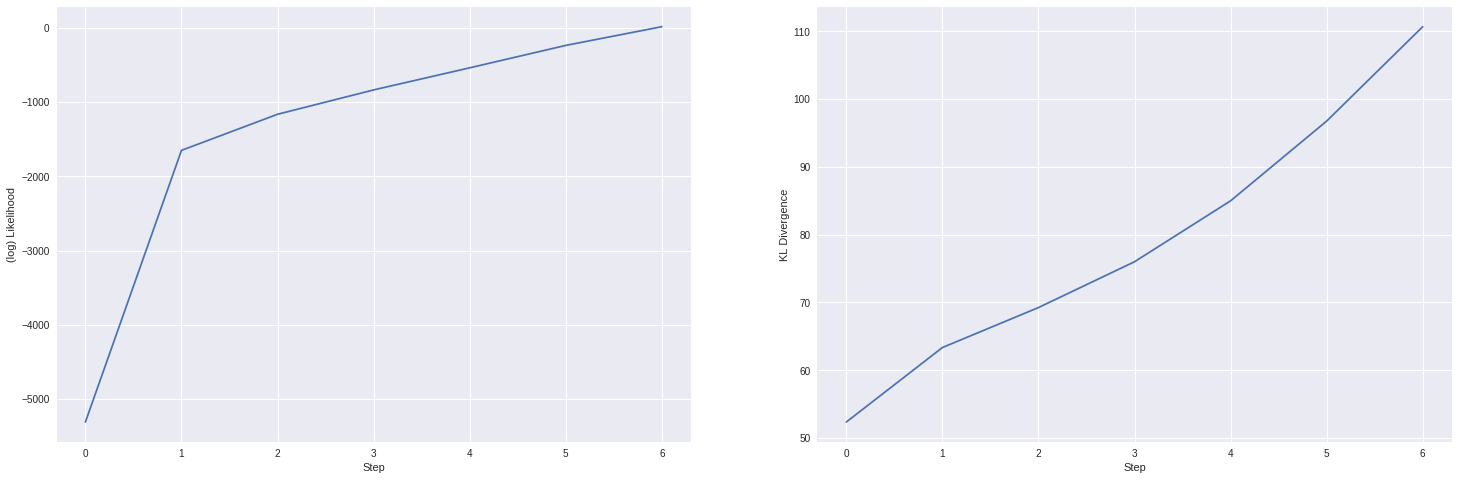

In [21]:
plt.style.use("seaborn")
plt.figure(figsize=(25, 8))

plt.subplot(1, 2, 1)
plt.plot(results["log_likelihood"][100::batches])
plt.xlabel("Step")
plt.ylabel("(log) Likelihood")

plt.subplot(1, 2, 2)
plt.plot(results["kl_divergence"][100::batches])
plt.xlabel("Step")
plt.ylabel("KL Divergence")

## Training the Classifier
The classifier is firstly trained in a fully supervised way using the labelled examples; at each training step, the model is evaluated on the training set and the most performing model is cloned and saved.

In [22]:
classifier = Classifier(768, 48, 3).cuda()
optimiser = optim.Adam(classifier.parameters(), lr=1e-3)

In [23]:
batch_size = 48
batches = ceil(len(training_inputs[0]) / batch_size)
step, steps_since_improvement, early_stopping = 0, 0, 4000

In [24]:
optimal_score, optimal_classifier_state_dict = None, None

In [25]:
results = {
    "training": {
        "cross_entropy": []
    },
    "testing": {
        "cross_entropy": []
    }
}

In [26]:
while steps_since_improvement < early_stopping:
    
    _, loss = classifier(*get_batch(step, batch_size, training_inputs))
    loss.backward()
    optimiser.step()
    classifier.zero_grad()
    
    results["training"]["cross_entropy"].append(float(loss))
    
    probabilities, loss = classifier(*testing_inputs)
    results["testing"]["cross_entropy"].append(float(loss))
    predictions = torch.argmax(probabilities, 1)
    scores = f1_score(testing.stances, predictions.cpu(), average=None)
    scores = (np.mean(scores[1:]), np.mean(scores[:]))
    
    score = np.mean(scores)
    
    if optimal_score is None or score > optimal_score:
        optimal_score = score
        optimal_classifier_state_dict = deepcopy(classifier.state_dict())
        steps_since_improvement = 0
    else:
        steps_since_improvement += 1
    
    step += 1

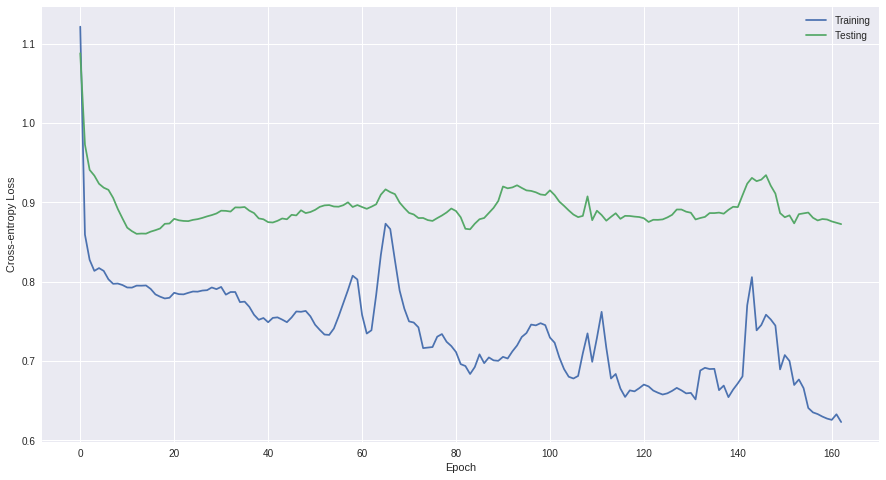

In [27]:
plt.style.use("seaborn")
plt.figure(figsize=(15, 8))

plt.plot(results["training"]["cross_entropy"][::batches])
plt.plot(results["testing"]["cross_entropy"][::batches])
plt.xlabel("Epoch")
plt.ylabel("Cross-entropy Loss")
plt.legend(["Training", "Testing"])

## VAE-C Training
In the following, the classifier is refined for classification by introducing the consistency objective.

In [28]:
vae = VAE(768, 48).cuda()
vae.load_state_dict(optimal_vae_state_dict)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [29]:
classifier = Classifier(768, 48, 3).cuda()
classifier.load_state_dict(optimal_classifier_state_dict)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [30]:
optimiser = optim.Adam(classifier.parameters(), lr=3e-4)
batch_size = 48
batches = ceil(len(training_inputs[0]) / batch_size)

In [31]:
step, steps_since_improvement, early_stopping = 0, 0, 4000

In [32]:
optimal_score, optimal_vaec_classifier_state_dict = None, None

In [33]:
results = {
    "training": {
        "cross_entropy": [],
        "kl_divergence": []
    },
    "testing": {
        "cross_entropy": [],
        "f_1_2": [],
        "f_1_3": []
    }
}

In [ ]:
while steps_since_improvement < early_stopping:
    
    classifier.zero_grad()
    
    batch = get_batch(step, batch_size, unlabelled_inputs)
    _, _, (_, likelihood) = vae(batch[0])
    reconstructions = likelihood.mean
    
    p1, cross_entropy = classifier(*get_batch(step, batch_size, training_inputs))
    p2_1, _ = classifier(batch[0])
    p2_2, _ = classifier(reconstructions)
    
    kl_div = nn.KLDivLoss(reduction="batchmean")
    ce = nn.CrossEntropyLoss()
    
    consistency_loss = kl_div(torch.log(p2_2), p2_1)
    
    results["training"]["cross_entropy"].append(float(cross_entropy))
    results["training"]["kl_divergence"].append(float(consistency_loss))
    
    loss = cross_entropy + consistency_loss
    
    loss.backward()
    optimiser.step()
    
    probabilities, loss = classifier(*testing_inputs)
    predictions = torch.argmax(probabilities, 1)
    scores = f1_score(testing.stances, predictions.cpu(), average=None)
    results["testing"]["cross_entropy"].append(loss)
    results["testing"]["f_1_2"].append(np.mean(scores[1:]))
    results["testing"]["f_1_3"].append(np.mean(scores[:]))
    scores = (np.mean(scores[1:]), np.mean(scores[:]))
    score = np.mean(scores)
    
    if optimal_score is None or score > optimal_score:
        optimal_score = score
        optimal_vaec_classifier_state_dict = deepcopy(classifier.state_dict())
        steps_since_improvement = 0
    else:
        steps_since_improvement += 1
    
    step += 1

In [ ]:
save_state_dict(optimal_vaec_classifier_state_dict, classifier_state_dict_name)

In [ ]:
plt.figure(figsize=(28, 8))

plt.subplot(1, 3, 1)
plt.plot(results["training"]["cross_entropy"][::batches])
plt.plot(results["testing"]["cross_entropy"][::batches])
plt.xlabel('Epoch')
plt.ylabel('Cross-entropy Loss')
plt.legend(["Training", "Testing"])
plt.title("Classification Performance")

plt.subplot(1, 3, 2)
plt.plot(results["training"]["kl_divergence"][::batches])
plt.xlabel('Epoch')
plt.ylabel('KL-Divergence')
plt.title("Consistency")

plt.subplot(1, 3, 3)
plt.plot(results["testing"]["f_1_2"][::batches])
plt.plot(results["testing"]["f_1_3"][::batches])
plt.xlabel("Epoch")
plt.ylabel("F1")
plt.title("Classification Metric")

## Evaluation
In the following cells, a comparison on the classification performance of the VAE-C model and its classifier taken independently before being refined is shown.

In [ ]:
classifier = Classifier(768, 48, 3).cuda()
classifier.load_state_dict(optimal_vaec_classifier_state_dict)
probabilities, _ = classifier(*testing_inputs)
predictions = torch.argmax(probabilities, 1)
print(classification_report(testing.stances, predictions.cpu()))
plot_confusion_matrix(testing.stances, predictions.cpu())

In [ ]:
classifier = Classifier(768, 48, 3).cuda()
classifier.load_state_dict(optimal_classifier_state_dict)
probabilities, _ = classifier(*testing_inputs)
predictions = torch.argmax(probabilities, 1)
print(classification_report(testing.stances, predictions.cpu()))
plot_confusion_matrix(testing.stances, predictions.cpu())